In order to run slicer with jupyter notebook firt pip_install('pip==new_version')
then pip_install('ipywidgets')

In [125]:
import sys
import os
from os.path import split, join
base_dir = split(os.getcwd())[0]
if base_dir not in sys.path:
    sys.path.append(base_dir)
import pickle
import slicer
import JupyterNotebooksLib as slicernb
import json
import pandas as pd

from slicer.ScriptedLoadableModule import *
from DICOMLib import DICOMUtils

slicernb.AppWindow.setWindowSize(scale=0.5)
slicernb.showSliceViewAnnotations(False)
#import matplotlib.pyplot as plt
#matplotlib.use('WXAgg')

#  Functions

In [126]:
import os
import subprocess
FILEBROWSER_PATH = os.path.join(os.getenv('WINDIR'), 'explorer.exe')

def explore(path):
    # explorer would choke on forward slashes
    path = os.path.normpath(path)

    if os.path.isdir(path):
        subprocess.run([FILEBROWSER_PATH, path])
    elif os.path.isfile(path):
        subprocess.run([FILEBROWSER_PATH, '/select,', os.path.normpath(path)])


In [18]:
def Appendtext(fname, text):
    with open(fname,'a+') as f:
        f.write(text)
    f.close()

## Directories 

In [123]:
data_dir = join(base_dir, 'data')
tables_dir = join(data_dir, 'tables')
data_long_dir = join(data_dir, 't1_longitudinal')
log_file = join(data_long_dir, 'results', 'failed_pred.txt')

with open(join(tables_dir, 'newIDs_dic.pkl'), 'rb') as f:
    id_dic = pickle.load(f)
with open(join(tables_dir, "disk_series_directories.json"), 'rb') as f:
    dir_dic = json.load(f)
inv_id_map = {v: k for k, v in id_dic.items()}
with open(join(data_long_dir, "failed_seg.pkl"), 'rb') as f:
    failed_seg_files = pickle.load(f)


df_volume_dir = pd.read_csv(join(tables_dir, 'series_directories.csv'))
sif_volume_dir_dic = pd.Series(
    df_volume_dir.Directory.values, index=df_volume_dir.SeriesInstanceUID)\
        .to_dict()

## Load dicoms into database

In [20]:
file_ids = [split(vol_file)[1][:6] for vol_file, _ in failed_seg_files]
dcm_dirs = [dir_dic[inv_id_map[file_id]] for file_id in file_ids] 
for dcm_dir in dcm_dirs[:5]:
    DICOMUtils.importDicom(dcm_dir)

In [21]:
print("There are now",len(DICOMUtils.allSeriesUIDsInDatabase()),'files in the database')

There are now 116 files in the database


## Show predictions 

## Nifti

F:\CoBra\Data\volume_longitudinal_nii\prediction\258402_1mm.nii.gz
new_id = 258402


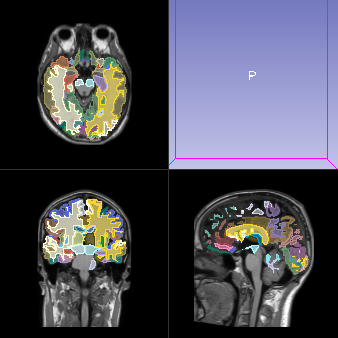

In [138]:
slicer.mrmlScene.Clear(False)
file_num = 89
examine_file_id = None#'008309'
if not isinstance(examine_file_id, type(None)):
    files_vol_seg = [f for f in failed_seg_files if examine_file_id in f[0]]
    print(files_vol_seg)
    vol_file, seg_file = files_vol_seg[0][0], files_vol_seg[0][1]
    print(vol_file)
    file_id = examine_file_id
else:
    vol_file, seg_file = failed_seg_files[file_num]
    file_id = split(vol_file)[1][:6]

volume = slicer.util.loadVolume(vol_file)
seg = slicer.util.loadSegmentation(seg_file)
print(vol_file)
print('new_id =', file_id)
slicernb.ViewDisplay("")


remove: 109983

In [85]:
text = 'cutoff'
text = '\n'+str(file_id) + ' ' + text
Appendtext(log_file, text)

## Dicom

F:\CoBra\Data\dcm\2019_01\aa45215cf7765cfbdb59284d231983fb\387fd68e417b277740e5a78cf84b7a3e
dcm_uid: 387fd68e417b277740e5a78cf84b7a3e
sif_dir: 2019_09\aa45215cf7765cfbdb59284d231983fb\a59d335ef59f78361b7b7d32d2489173\MR\387fd68e417b277740e5a78cf84b7a3e
Loading with imageIOName: GDCM
Window/level found in DICOM tags (center=7.68, width=13.05) has been applied to volume 201: ADNI MPRAGE


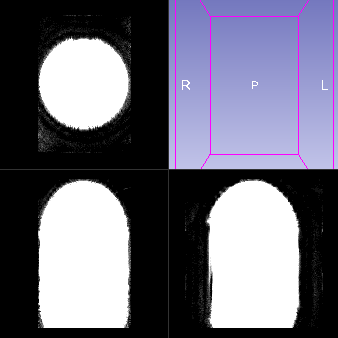

In [117]:
dcm_dir = dir_dic[inv_id_map[file_id]]
#dcm_files = [join(dcm_dir, file) for file in os.listdir(dcm_dir)]
dcm_uid = split(dcm_dir)[1]
print(dcm_dir)
print('dcm_uid:', dcm_uid)
print('sif_dir:', sif_volume_dir_dic[dcm_uid])
slicer.mrmlScene.Clear(False)
volume = DICOMUtils.loadSeriesByUID([dcm_uid])
slicernb.ViewDisplay()

In [18]:
print(split(split(vol_file)[0])[0])

F:\CoBra\Data\volume_longitudinal_nii


In [29]:
remove_niis_and_pred = True
if remove_niis_and_pred:
    os.remove(vol_file)
    os.remove(seg_file)
    os.remove(join(split(vol_file)[0], file_id+'_seg.nii.gz'))
    os.remove(join(split(split(vol_file)[0])[0], 'input', 'nii_files', file_id+'.nii.gz'))

## Dynamic 3d 

In [11]:
slicernb.showVolumeRendering(volume, show=True)
app = slicernb.AppWindow()
app

TypeError: GetFirstVolumeRenderingDisplayNode argument 1: method requires a VTK object